# Content-based recommender using Natural Language Processing (NLP)
## A guide to build a content-based recommender model based on NLP

IMDB top 250 English movies dataset is taken from data.world https://data.world/studentoflife/imdb-top-250-lists-and-5000-or-so-data-records

The attributes used for similarity comparison/calculation includes genre, plot, director and (three) main actors.

## Step 1: import Python libraries and dataset, perform EDA
Ensure that the Rapid Automatic Keyword Extraction (RAKE) library has been installed (or pip install rake_nltk). Refer to https://pypi.org/project/rake-nltk/ for more information.

In [44]:
# !pip install rake_nltk
from rake_nltk import Rake   # ensure this is installed

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [160]:
# df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')   # 250 rows × 38 columns
df = pd.read_csv('IMDB_Top250Engmovies2_OMDB_Detailed.csv')   # same data 250 rows × 38 columns
df

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,...,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and Shawshank R...","Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_redemption/,27 Jan 1998,NaN,Columbia Pictures,NaN,True
1,2,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola (screenpla...","Marlon Brando, Al Pacino, James Caan, Richard S. Castellano",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather/,09 Oct 2001,NaN,Paramount Pictures,http://www.thegodfather.com,True
2,3,The Godfather: Part II,1974,R,20 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay), Mario Puzo (screenpla...","Al Pacino, Robert Duvall, Diane Keaton, Robert De Niro",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather_part_ii/,24 May 2005,NaN,Paramount Pictures,http://www.thegodfather.com/,True
3,4,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan (screenpl...","Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/the_dark_knight/,09 Dec 2008,"$533,316,061",Warner Bros. Pictures/Legendary,http://thedarkknight.warnerbros.com/,True
4,5,12 Angry Men,1957,APPROVED,01 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,"Reginald Rose (story), Reginald Rose (screenplay)","Martin Balsam, John Fiedler, Lee J. Cobb, E.G. Marshall",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/1000013-12_angry_men/,06 Mar 2001,NaN,Criterion Collection,http://www.criterion.com/films/27871-12-angry-men,True
5,6,Schindler's List,1993,R,04 Feb 1994,195 min,"Biography, Drama, History",Steven Spielberg,"Thomas Keneally (book), Steven Zaillian (screenplay)","Liam Neeson, Ben Kingsley, Ralph Fiennes, Caroline Goodall",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/schindlers_list/,09 Mar 2004,NaN,Universal Pictures,http://www.schindlerslist.com,True
6,7,The Lord of the Rings: The Return of the King,2003,PG-13,17 Dec 2003,201 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay), Philipp...","Noel Appleby, Ali Astin, Sean Astin, David Aston",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/the_lord_of_the_rings_th...,25 May 2004,"$364,000,000",New Line Cinema,http://www.lordoftherings.net/,True
7,8,Pulp Fiction,1994,R,14 Oct 1994,154 min,"Crime, Drama",Quentin Tarantino,"Quentin Tarantino (stories), Roger Avary (stories), Quen...","Tim Roth, Amanda Plummer, Laura Lovelace, John Travolta",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/pulp_fiction/,19 May 1998,NaN,Miramax Films,NaN,True
8,9,Fight Club,1999,R,15 Oct 1999,139 min,Drama,David Fincher,"Chuck Palahniuk (novel), Jim Uhls (screenplay)","Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/fight_club/,06 Jun 2000,NaN,20th Century Fox,http://www.foxmovies.com/fightclub/,True
9,10,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,19 Dec 2001,178 min,"Adventure, Drama, Fantasy",Peter Jackson,"J.R.R. Tolkien (novel), Fran Walsh (screenplay), Philipp...","Alan Howard, Noel Appleby, Sean Astin, Sala Baker",...,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/the_lord_of_the_rings_th...,06 Aug 2002,"$314,000,000",New Line Cinema,http://www.lordoftherings.net/film/trilogy/thefellowship...,True


In [161]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  250
Columns  :  38

Features :  ['Unnamed: 0', 'Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings.Source', 'Ratings.Value', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type', 'tomatoMeter', 'tomatoImage', 'tomatoRating', 'tomatoReviews', 'tomatoFresh', 'tomatoRotten', 'tomatoConsensus', 'tomatoUserMeter', 'tomatoUserRating', 'tomatoUserReviews', 'tomatoURL', 'DVD', 'BoxOffice', 'Production', 'Website', 'Response']

Missing values :   2878

Unique values :  
 Unnamed: 0           250
Title                250
Year                  85
Rated                 10
Released             244
Runtime              103
Genre                110
Director             155
Writer               238
Actors               248
Plot                 250
Language              68
Country               39
Awards               235
Poster               250
Ratings.Source         1
Ratings.Value      

In [8]:
# type of entries, how many null fields
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
Title       250 non-null object
Director    250 non-null object
Actors      250 non-null object
Plot        250 non-null object
Genre       250 non-null object
dtypes: object(5)
memory usage: 9.8+ KB


Title       0
Director    0
Actors      0
Plot        0
Genre       0
dtype: int64

In [9]:
# summary statistics for all numerical columns
df.describe().T

,count,unique,top,freq
Title,250,250,Warrior,1
Director,250,155,Alfred Hitchcock,9
Actors,250,248,"Mark Hamill, Harrison Ford, Carrie Fisher, Bil...",2
Plot,250,250,An astronaut becomes stranded on Mars after hi...,1
Genre,250,110,Drama,19


In [162]:
# keep only these 5 useful columns, 250 rows with no NaN field
df = df[['Title','Director','Actors','Plot','Genre']]
df

,Title,Director,Actors,Plot,Genre
0,The Shawshank Redemption,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler","Two imprisoned men bond over a number of years, finding ...","Crime, Drama"
1,The Godfather,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard S. Castellano",The aging patriarch of an organized crime dynasty transf...,"Crime, Drama"
2,The Godfather: Part II,Francis Ford Coppola,"Al Pacino, Robert Duvall, Diane Keaton, Robert De Niro",The early life and career of Vito Corleone in 1920s New ...,"Crime, Drama"
3,The Dark Knight,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine",When the menace known as the Joker emerges from his myst...,"Action, Crime, Drama"
4,12 Angry Men,Sidney Lumet,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G. Marshall",A jury holdout attempts to prevent a miscarriage of just...,"Crime, Drama"
5,Schindler's List,Steven Spielberg,"Liam Neeson, Ben Kingsley, Ralph Fiennes, Caroline Goodall","In German-occupied Poland during World War II, Oskar Sch...","Biography, Drama, History"
6,The Lord of the Rings: The Return of the King,Peter Jackson,"Noel Appleby, Ali Astin, Sean Astin, David Aston",Gandalf and Aragorn lead the World of Men against Sauron...,"Adventure, Drama, Fantasy"
7,Pulp Fiction,Quentin Tarantino,"Tim Roth, Amanda Plummer, Laura Lovelace, John Travolta","The lives of two mob hit men, a boxer, a gangster's wife...","Crime, Drama"
8,Fight Club,David Fincher,"Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier","An insomniac office worker, looking for a way to change ...",Drama
9,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,"Alan Howard, Noel Appleby, Sean Astin, Sala Baker",A meek Hobbit from the Shire and eight companions set ou...,"Adventure, Drama, Fantasy"


In [13]:
df.loc[(df.Genre == 'Drama')]

,Title,Director,Actors,Plot,Genre
8,Fight Club,David Fincher,"Edward Norton, Brad Pitt, Meat Loaf, Zach Grenier","An insomniac office worker, looking for a way ...",Drama
14,One Flew Over the Cuckoo's Nest,Milos Forman,"Michael Berryman, Peter Brocco, Dean R. Brooks...",A criminal pleads insanity after getting into ...,Drama
63,Requiem for a Dream,Darren Aronofsky,"Ellen Burstyn, Jared Leto, Jennifer Connelly, ...",The drug-induced utopias of four Coney Island ...,Drama
81,All About Eve,Joseph L. Mankiewicz,"Bette Davis, Anne Baxter, George Sanders, Cele...",An ingenue insinuates herself into the company...,Drama
85,Good Will Hunting,Gus Van Sant,"Matt Damon, Ben Affleck, Stellan Skarsgård, Jo...","Will Hunting, a janitor at M.I.T., has a gift ...",Drama
105,Room,Lenny Abrahamson,"Brie Larson, Jacob Tremblay, Sean Bridgers, We...",A young boy is raised within the confines of a...,Drama
121,Trainspotting,Danny Boyle,"Ewan McGregor, Ewen Bremner, Jonny Lee Miller,...","Renton, deeply immersed in the Edinburgh drug ...",Drama
124,Gran Torino,Clint Eastwood,"Clint Eastwood, Christopher Carley, Bee Vang, ...",Disgruntled Korean War veteran Walt Kowalski s...,Drama
139,Network,Sidney Lumet,"Faye Dunaway, William Holden, Peter Finch, Rob...",A television network cynically exploits a dera...,Drama
170,"Paris, Texas",Wim Wenders,"Harry Dean Stanton, Sam Berry, Bernhard Wicki,...","Travis Henderson, an aimless drifter who has b...",Drama


In [14]:
# top genres (from 110 unique genres)
df['Genre'].value_counts()

Drama                           19
Crime, Drama                    14
Drama, War                       9
Animation, Adventure, Comedy     8
Crime, Drama, Thriller           8
Biography, Drama, History        7
Crime, Drama, Mystery            7
Action, Adventure, Sci-Fi        6
Action, Adventure, Fantasy       6
Biography, Drama                 6
Crime, Drama, Film-Noir          5
Drama, Romance                   5
Adventure, Drama, Fantasy        5
Comedy, Romance                  5
Comedy, Crime                    4
Mystery, Thriller                4
Biography, Crime, Drama          4
Comedy, Drama, Romance           4
Adventure, Biography, Drama      3
Action, Sci-Fi                   3
Adventure, Drama, History        3
Adventure, Drama, Thriller       3
Comedy                           3
Comedy, Drama                    3
Drama, Sport                     3
Animation, Family, Fantasy       2
Adventure, Family, Fantasy       2
Adventure, Comedy, Drama         2
Action, Adventure, C

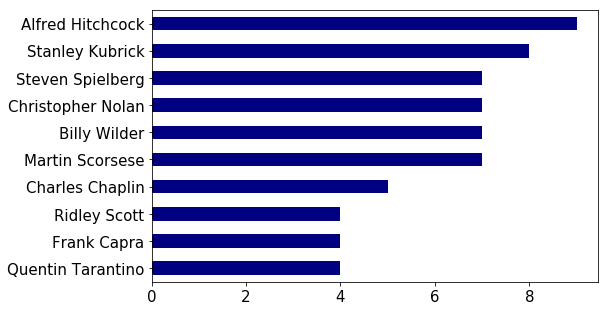

In [164]:
# 10 popular directors (from 155 unique directors)
df['Director'].value_counts()[0:10].plot('barh', figsize=[8,5], fontsize=15, color='navy').invert_yaxis()

## Step 2: data pre-processing

Firstly the data has to be pre-processed using NLP to obtain only one column that contains all the attributes (in words) of each movie. After that, this information is converted into numbers by vectorization, where scores are assigned to each word. Subsequently cosine similarities can be calculated.

### to remove stop words, punctuation, white space, and convert all words to lower case
I used the Rake function to extract the most relevant words from whole sentences in the Plot column. In order to do this, I applied this function to each row under the Plot column and assigned the list of key words to a new column 'Key_words'.

In [155]:
# to extract key words from Plot
df['Key_words'] = ''   # initializing a new column
r = Rake()   # use Rake to discard punctuations and stop words (based on english stopwords from NLTK)

for index, row in df.iterrows():
    r.extract_keywords_from_text(row['Plot'])   # to extract key words from Plot, default in lower case
    key_words_dict_scores = r.get_word_degrees()   # to get dictionary with key words and their scores
    row['Key_words'] = list(key_words_dict_scores.keys())   # to assign list of key words to new column

df.head()

,Title,Director,Actors,Plot,Genre,Key_words
0,The Shawshank Redemption,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler","Two imprisoned men bond over a number of years, finding ...","Crime, Drama","[finding, solace, years, acts, number, eventual, redempt..."
1,The Godfather,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard S. Castellano",The aging patriarch of an organized crime dynasty transf...,"Crime, Drama","[aging, patriarch, organized, crime, dynasty, transfers,..."
2,The Godfather: Part II,Francis Ford Coppola,"Al Pacino, Robert Duvall, Diane Keaton, Robert De Niro",The early life and career of Vito Corleone in 1920s New ...,"Crime, Drama","[portrayed, 1920s, new, york, family, crime, syndicate, ..."
3,The Dark Knight,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine",When the menace known as the Joker emerges from his myst...,"Action, Crime, Drama","[mysterious, past, gotham, ability, dark, knight, must, ..."
4,12 Angry Men,Sidney Lumet,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G. Marshall",A jury holdout attempts to prevent a miscarriage of just...,"Crime, Drama","[miscarriage, jury, holdout, attempts, colleagues, justi..."


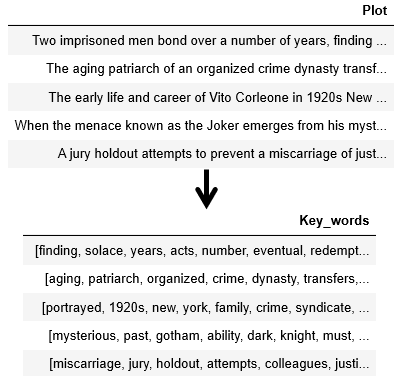

In [152]:
key_words_dict_scores

defaultdict(<function rake_nltk.rake.Rake._build_word_co_occurance_graph.<locals>.<lambda>()>,
            {'millionaire': 2,
             '?"': 2,
             'indian': 2,
             'version': 2,
             'slums': 1,
             'wants': 1,
             'upbringing': 1,
             'mumbai': 3,
             'teen': 3,
             'reflects': 3,
             'cheating': 1,
             'accused': 1})

In [154]:
df['Plot'][249]

'A Mumbai teen reflects on his upbringing in the slums when he is accused of cheating on the Indian Version of "Who Wants to be a Millionaire?"'

In [153]:
df['Key_words'][249]

['millionaire',
 '?"',
 'indian',
 'version',
 'slums',
 'wants',
 'upbringing',
 'mumbai',
 'teen',
 'reflects',
 'cheating',
 'accused']

The names of actors and directors are transformed into unique identity values. This is done by merging all first and last names into one word, so that Chris Evans and Chris Hemsworth will appear different. The recommender should detect a similarity only if the person associated to different movies is exactly the same. Every word needs to be converted to lowercase to avoid duplications.

In [143]:
# to extract all genre into a list, only the first three actors into a list, and all directors into a list
df['Genre'] = df['Genre'].map(lambda x: x.split(','))
df['Actors'] = df['Actors'].map(lambda x: x.split(',')[:3])
df['Director'] = df['Director'].map(lambda x: x.split(','))

# create unique identity names by merging first & last name into one word, convert to lowercase 
for index, row in df.iterrows():
    row['Genre'] = [x.lower().replace(' ','') for x in row['Genre']]
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = [x.lower().replace(' ','') for x in row['Director']]
df

,Title,Director,Actors,Plot,Genre,Key_words
0,The Shawshank Redemption,[frankdarabont],"[timrobbins, morganfreeman, bobgunton]","Two imprisoned men bond over a number of years, finding ...","[crime, drama]","[finding, solace, years, acts, number, eventual, redempt..."
1,The Godfather,[francisfordcoppola],"[marlonbrando, alpacino, jamescaan]",The aging patriarch of an organized crime dynasty transf...,"[crime, drama]","[aging, patriarch, organized, crime, dynasty, transfers,..."
2,The Godfather: Part II,[francisfordcoppola],"[alpacino, robertduvall, dianekeaton]",The early life and career of Vito Corleone in 1920s New ...,"[crime, drama]","[portrayed, 1920s, new, york, family, crime, syndicate, ..."
3,The Dark Knight,[christophernolan],"[christianbale, heathledger, aaroneckhart]",When the menace known as the Joker emerges from his myst...,"[action, crime, drama]","[mysterious, past, gotham, ability, dark, knight, must, ..."
4,12 Angry Men,[sidneylumet],"[martinbalsam, johnfiedler, leej.cobb]",A jury holdout attempts to prevent a miscarriage of just...,"[crime, drama]","[miscarriage, jury, holdout, attempts, colleagues, justi..."
5,Schindler's List,[stevenspielberg],"[liamneeson, benkingsley, ralphfiennes]","In German-occupied Poland during World War II, Oskar Sch...","[biography, drama, history]","[oskar, schindler, gradually, becomes, concerned, world,..."
6,The Lord of the Rings: The Return of the King,[peterjackson],"[noelappleby, aliastin, seanastin]",Gandalf and Aragorn lead the World of Men against Sauron...,"[adventure, drama, fantasy]","[army, draw, one, ring, world, gandalf, sam, men, frodo,..."
7,Pulp Fiction,[quentintarantino],"[timroth, amandaplummer, lauralovelace]","The lives of two mob hit men, a boxer, a gangster's wife...","[crime, drama]","[redemption, pair, lives, boxer, gangster, wife, diner, ..."
8,Fight Club,[davidfincher],"[edwardnorton, bradpitt, meatloaf]","An insomniac office worker, looking for a way to change ...",[drama],"[crosses, paths, care, soap, maker, forming, insomniac, ..."
9,The Lord of the Rings: The Fellowship of the Ring,[peterjackson],"[alanhoward, noelappleby, seanastin]",A meek Hobbit from the Shire and eight companions set ou...,"[adventure, drama, fantasy]","[shire, dark, lord, sauron, journey, powerful, one, ring..."


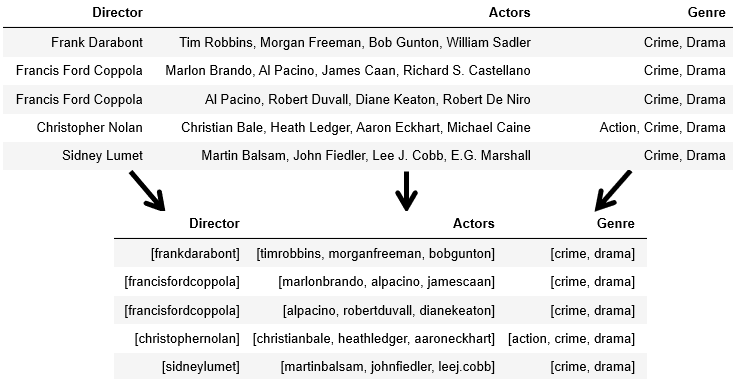

## Step 3: create word representation by combining column attributes to Bag_of_words

In [144]:
df['Bag_of_words'] = ''
columns = ['Genre', 'Director', 'Actors', 'Key_words']

for index, row in df.iterrows():
    words = ''
    for col in columns:
        words += ' '.join(row[col]) + ' '
    row['Bag_of_words'] = words
    
df = df[['Title','Bag_of_words']]
df

,Title,Bag_of_words
0,The Shawshank Redemption,crime drama frankdarabont timrobbins morganfreeman bobgu...
1,The Godfather,crime drama francisfordcoppola marlonbrando alpacino jam...
2,The Godfather: Part II,crime drama francisfordcoppola alpacino robertduvall dia...
3,The Dark Knight,action crime drama christophernolan christianbale heathl...
4,12 Angry Men,crime drama sidneylumet martinbalsam johnfiedler leej.co...
5,Schindler's List,biography drama history stevenspielberg liamneeson benki...
6,The Lord of the Rings: The Return of the King,adventure drama fantasy peterjackson noelappleby aliasti...
7,Pulp Fiction,crime drama quentintarantino timroth amandaplummer laura...
8,Fight Club,drama davidfincher edwardnorton bradpitt meatloaf crosse...
9,The Lord of the Rings: The Fellowship of the Ring,adventure drama fantasy peterjackson alanhoward noelappl...


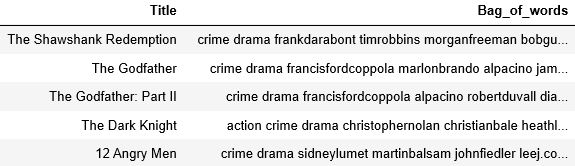

In [122]:
df['Bag_of_words'][0]

'crime drama frankdarabont timrobbins morganfreeman bobgunton finding solace years acts number eventual redemption common decency two imprisoned men bond '

## Step 4: create vector representation for Bag_of_words and the similarity matrix

The recommender model can only read and compare a vector (matrix) with another, so we need to convert the 'Bag_of_words' into vector representation using CountVectorizer, which is a simple frequency counter for each word in the bag_of_words column. Once I have the matrix containing the count for each word, I can apply the cosine_similarity function to compare similarities between movies.

In [145]:
# to generate the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['Bag_of_words'])
count_matrix

0    The Shawshank Redemption
1               The Godfather
2      The Godfather: Part II
3             The Dark Knight
4                12 Angry Men
Name: Title, dtype: object

In [146]:
# to generate the cosine similarity matrix (size 250 x 250)
# rows represent all movies; columns represent all movies
# cosine similarity: similarity = cos(angle) = range from 0 (different) to 1 (similar)
# all the numbers on the diagonal are 1 because every movie is identical to itself (cosine value is 1 means exactly identical)
# matrix is also symmetrical because the similarity between A and B is the same as the similarity between B and A.
# for other values eg 0.1578947, movie x and movie y has similarity value of 0.1578947

cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.15789474 0.13764944 ... 0.05263158 0.05263158 0.05564149]
 [0.15789474 1.         0.36706517 ... 0.05263158 0.05263158 0.05564149]
 [0.13764944 0.36706517 1.         ... 0.04588315 0.04588315 0.04850713]
 ...
 [0.05263158 0.05263158 0.04588315 ... 1.         0.05263158 0.05564149]
 [0.05263158 0.05263158 0.04588315 ... 0.05263158 1.         0.05564149]
 [0.05564149 0.05564149 0.04850713 ... 0.05564149 0.05564149 1.        ]]


### Similarity Matrix
Next is to create a Series of movie titles, so that the series index can match the row/column index of the similarity matrix

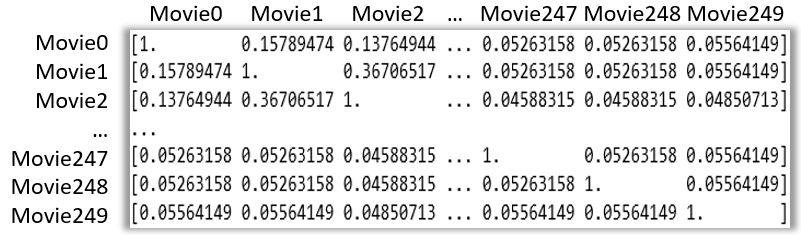

In [ ]:
# to create a Series for movie titles which can be used as indices (each index is mapped to a movie title)
indices = pd.Series(df['Title'])
indices[:5]

## Step 5: run and test the recommender model
The final step is to create a function that takes a movie title as input, and returns the top 10 similar movies. This function will match the input movie title with the corresponding index of the Similarity Matrix, and extract the row of similarity values in descending order. The top 10 similar movies can be found by extracting the top 11 values and subsequently discarding the first index which is the input movie itself)

In [ ]:
def recommend(title, cosine_sim = cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        recommended_movies.append(list(df['Title'])[i])
        
    return recommended_movies

In [158]:
# this function takes in a movie title as input and returns the top 10 recommended (similar) movies

def recommend(title, cosine_sim = cosine_sim):
    recommended_movies = []
    idx = indices[indices == title].index[0]   # to get the index of the movie title matching the input movie
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_10_indices = list(score_series.iloc[1:11].index)   # to get the indices of top 10 most similar movies
    # [1:11] to exclude 0 (index 0 is the input movie itself)
    
    for i in top_10_indices:   # to append the titles of top 10 similar movies to the recommended_movies list
        recommended_movies.append(list(df['Title'])[i])
        
    return recommended_movies

recommend('The Dark Knight')

['The Dark Knight Rises',
 'Batman Begins',
 'The Prestige',
 'The Green Mile',
 'Witness for the Prosecution',
 'Out of the Past',
 'Rush',
 'The Godfather',
 'V for Vendetta',
 'Reservoir Dogs']

In [159]:
recommend('The Avengers')

['Guardians of the Galaxy Vol. 2',
 'Aliens',
 'Guardians of the Galaxy',
 'The Martian',
 'Interstellar',
 'Blade Runner',
 'Terminator 2: Judgment Day',
 'The Thing',
 'The Terminator',
 'Spider-Man: Homecoming']

In [127]:
recommend('Fargo')

['No Country for Old Men',
 'The Departed',
 'Rope',
 'The Godfather',
 'Reservoir Dogs',
 'The Godfather: Part II',
 'On the Waterfront',
 'Goodfellas',
 'Arsenic and Old Lace',
 'The Big Lebowski']

## Conclusion
The model has recommended very similar movies. From my "domain knowledge", I can see some similarities mainly based on directors and plot. I have already watched most of these recommended movies, and will look forward to watch those few unseen ones.